<a href="https://colab.research.google.com/github/MonikSense/TFT-rGO-/blob/main/TFT_paper_1_rGO_SVR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   Voltage   Current  gas conc. (ppm)
0      0.0  0.000005                0
1      0.2  0.014300                0
2      0.4  0.028500                0
3      0.6  0.042500                0
4      0.8  0.056900                0
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'C': 10, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}
Test Mean Squared Error: 0.0001
Cross-Validation RMSE scores: [0.02436271 0.0118671  0.05847025 0.75712173 1.31408438]
Mean CV RMSE: 0.43318123339558295


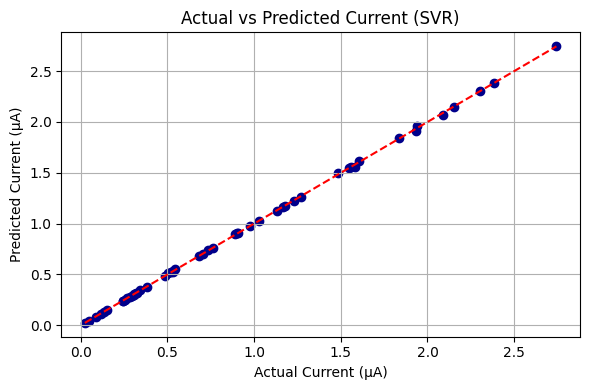

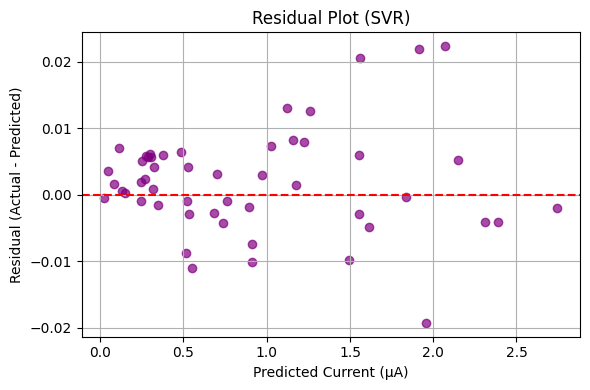

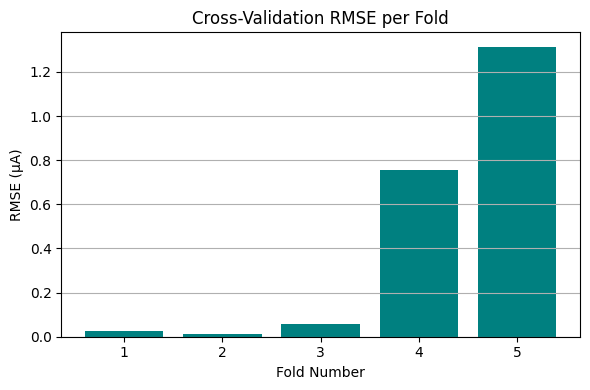

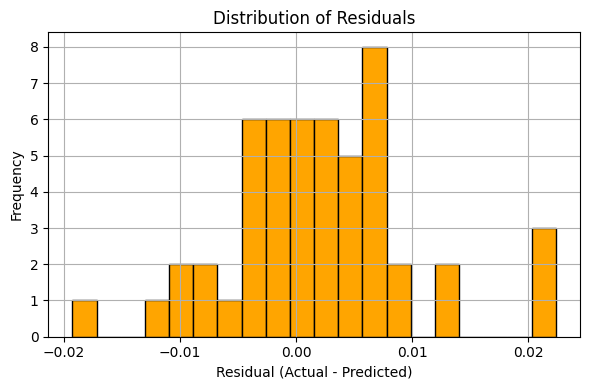

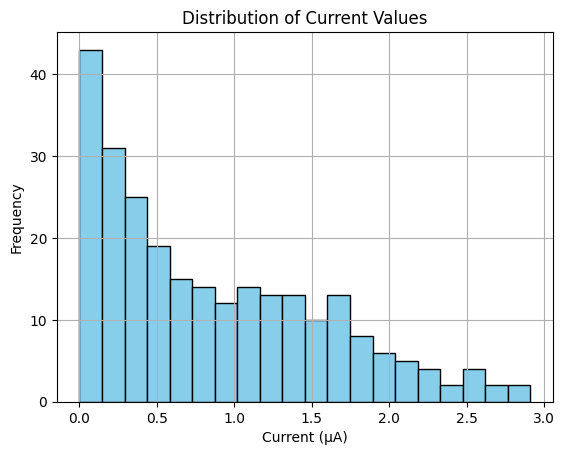

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV file
url = "https://raw.githubusercontent.com/MonikSense/MonikSense/refs/heads/main/TFT%20paper4%20final3.CSV"
df = pd.read_csv(url)

# Preview data
print(df.head())

# Define features and target
X = df[['Voltage', 'gas conc. (ppm)']]
y = df['Current']

# --- Feature Scaling (important for SVR) ---
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Define base model
svr = SVR()

# Hyperparameter grid
param_grid = {
    'kernel': ['rbf', 'poly'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.01, 0.1, 0.2]
}

# GridSearchCV
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best estimator
best_svr = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Predict and evaluate
y_pred_scaled = best_svr.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

mse = mean_squared_error(y_test_original, y_pred)
print(f"Test Mean Squared Error: {mse:.4f}")

# --- Cross-validation on best model ---
cv_scores = cross_val_score(best_svr, X_scaled, y_scaled, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print("Cross-Validation RMSE scores:", cv_rmse)
print("Mean CV RMSE:", np.mean(cv_rmse))

# --- Actual vs Predicted Plot ---
plt.figure(figsize=(6, 4))
plt.scatter(y_test_original, y_pred, color='darkblue')
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], 'r--')
plt.xlabel("Actual Current (μA)")
plt.ylabel("Predicted Current (μA)")
plt.title("Actual vs Predicted Current (SVR)")
plt.grid(True)
plt.tight_layout()
plt.show()


# Residuals
residuals = y_test_original - y_pred

plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals, color='purple', alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Current (μA)")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot (SVR)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Cross-validation RMSEs
cv_rmse = np.array([0.0244, 0.0119, 0.0585, 0.7571, 1.3141])  # from your result

plt.figure(figsize=(6, 4))
plt.bar(range(1, 6), cv_rmse, color='teal')
plt.xlabel("Fold Number")
plt.ylabel("RMSE (µA)")
plt.title("Cross-Validation RMSE per Fold")
plt.xticks(range(1, 6))
plt.grid(axis='y')
plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=20, color='orange', edgecolor='black')
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()


plt.hist(y, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Current Values")
plt.xlabel("Current (µA)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
